<a href="https://colab.research.google.com/github/dhananjay-25/AIQUANTUM-Internship/blob/main/skin_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer detection Model using AlexNet, VGG16 & VGG19

In [ ]:
!pip install tensorflow pandas matplotlib seaborn



## Impoting libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import glob


## Loading and Preprocessing Data


In [4]:
# Load metadata
from google.colab import files


# Assuming the metadata CSV is uploaded
metadata = pd.read_csv('HAM10000_metadata.csv')

# Display the first few rows of the metadata
metadata.head()


# Define the directory where images are stored
image_dir = '/content/imagesdata'

# Create a dictionary mapping image filenames (without extensions) to their full paths
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(image_dir, '*.jpg'))}

# Add a column in metadata with the corresponding image file paths
metadata['image_path'] = metadata['image_id'].map(image_paths.get)

# Drop rows where the image path is missing
metadata.dropna(inplace=True)

# Display the updated metadata
metadata.head()


# Encode the labels
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['dx'])

# Convert numerical labels to strings
metadata['label'] = metadata['label'].astype(str)


# Display the unique labels and their encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Split the data into train and test sets
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_vgg16,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Found 1558 validated image filenames belonging to 7 classes.
Found 390 validated image filenames belonging to 7 classes.


# Define Models

## AlexNet


In [5]:
def alexnet_model(input_shape=(224, 224, 3), n_classes=7):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    return model

alexnet = alexnet_model()
alexnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


## VGG16 & VGG19

In [6]:
def create_model(base_model, preprocess_input, input_shape=(224, 224, 3), n_classes=7):
    base = base_model(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg16 = create_model(VGG16, preprocess_vgg16)
vgg19 = create_model(VGG19, preprocess_vgg19)


80134624/80134624 [==============================] - 0s 0us/step


## Training Model

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train AlexNet
history_alexnet = alexnet.fit(train_generator, validation_data=test_generator, epochs=50, callbacks=callbacks)

# Train VGG16
history_vgg16 = vgg16.fit(train_generator, validation_data=test_generator, epochs=50, callbacks=callbacks)

# Train VGG19
history_vgg19 = vgg19.fit(train_generator, validation_data=test_generator, epochs=50, callbacks=callbacks)


Epoch 1/50
49/49 [==============================] - 38s 771ms/step - loss: 0.5760 - accuracy: 0.7831 - val_loss: 0.7544 - val_accuracy: 0.7462
Epoch 2/50
49/49 [==============================] - 34s 690ms/step - loss: 0.5655 - accuracy: 0.7953 - val_loss: 0.7816 - val_accuracy: 0.7410
Epoch 3/50
49/49 [==============================] - 31s 637ms/step - loss: 0.5729 - accuracy: 0.7843 - val_loss: 0.7824 - val_accuracy: 0.7718
Epoch 4/50
49/49 [==============================] - 29s 600ms/step - loss: 0.5695 - accuracy: 0.7920 - val_loss: 0.7781 - val_accuracy: 0.7487
Epoch 5/50
49/49 [==============================] - 42s 867ms/step - loss: 0.5481 - accuracy: 0.7959 - val_loss: 0.6203 - val_accuracy: 0.7564
Epoch 6/50
49/49 [==============================] - 29s 602ms/step - loss: 0.5267 - accuracy: 0.8081 - val_loss: 0.6443 - val_accuracy: 0.8000
Epoch 7/50
49/49 [==============================] - 30s 608ms/step - loss: 0.5432 - accuracy: 0.7940 - val_loss: 0.6867 - val_accuracy: 0.7615

## Evaluating models

In [13]:
# Evaluate AlexNet
alexnet.evaluate(test_generator)

# Evaluate VGG16
vgg16.evaluate(test_generator)

# Evaluate VGG19
vgg19.evaluate(test_generator)


13/13 [==============================] - 3s 238ms/step - loss: 0.6931 - accuracy: 0.7949


[0.693057656288147, 0.7948718070983887]

## Visualization

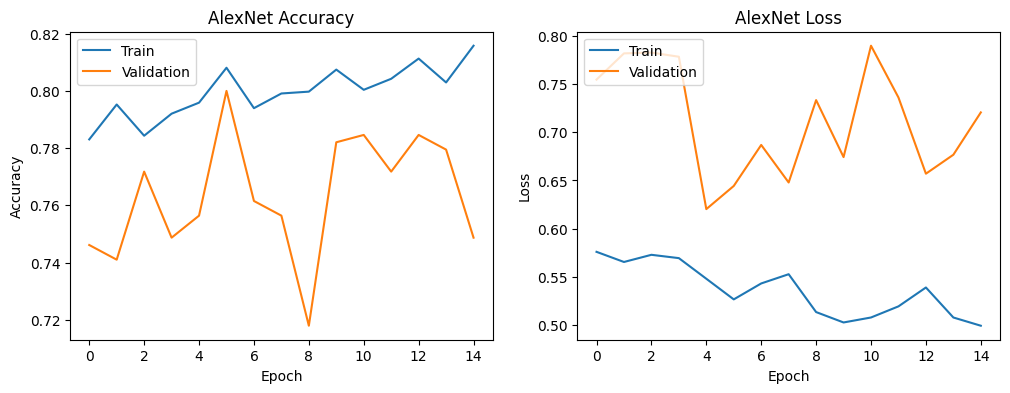

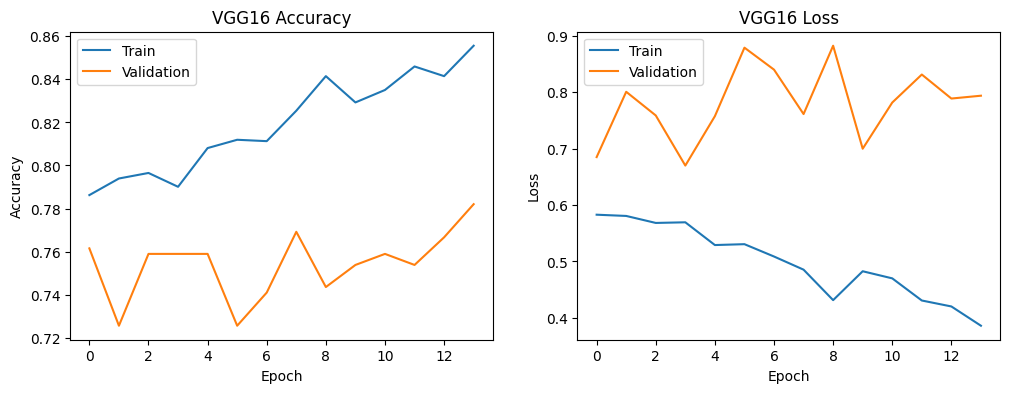

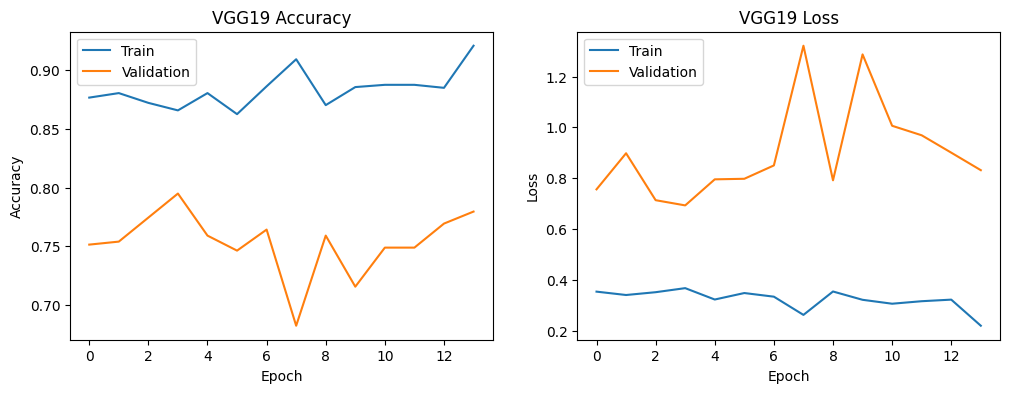

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history_alexnet, 'AlexNet')
plot_history(history_vgg16, 'VGG16')
plot_history(history_vgg19, 'VGG19')
